# 5.2 グリッドサーチ grid seach

# 最適なパラメータ設定

例　２章p90 カーネル法を用いたSVM
https://github.com/amueller/introduction_to_ml_with_python/blob/master/02-supervised-learning.ipynb
[74]～[86] 特に[80]
Cとgammaの調整が要必要

5.2.1　単純なグリッドサーチ パラメータの全ての組合を考える

In [1]:
%matplotlib inline

In [2]:
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score #交差検証
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
import os
from tempfile import mkstemp
import subprocess
from IPython.display import Image
from IPython.core.display import display
from sklearn.svm import SVC
from sklearn.tree.export import export_graphviz



import mglearn 

In [3]:
iris = load_iris()  #データ　
logreg = LogisticRegression()

In [4]:
IRISDATA = pd.DataFrame(iris.data , columns=["sepal length(cm)","sepal witdh(cm)","petal length(cm)","petal width"])
# sepal ガク　petal　花弁
IRISDATA.tail(n=5)

,sepal length(cm),sepal witdh(cm),petal length(cm),petal width
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3
149,5.9,3.0,5.1,1.8


In [5]:
from sklearn.svm import SVC
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target,random_state=0)

print("Size of training set: {}   size of test set: {}".format(X_train.shape[0], X_test.shape[0]))

best_score = 0

for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        # for each combination of parameters, train an SVC
        svm = SVC(gamma=gamma, C=C)
        svm.fit(X_train, y_train)
        # evaluate the SVC on the test set
        score = svm.score(X_test, y_test)
        # if we got a better score, store the score and parameters
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}

print("loop number: {:d}".format(6*6))
print("Best score: {:.2f}".format(best_score))
print("Best parameters: {}".format(best_parameters))

Size of training set: 112   size of test set: 38
loop number: 36
Best score: 0.97
Best parameters: {'C': 100, 'gamma': 0.001}


これまで通り…

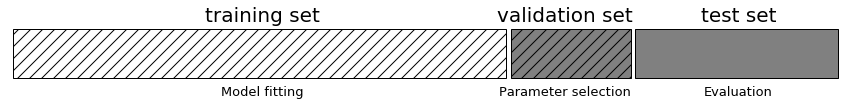

In [6]:
mglearn.plots.plot_threefold_split()

In [7]:
from sklearn.svm import SVC
# split data into train+validation set and test set
X_trainval, X_test, y_trainval, y_test = train_test_split(
    iris.data, iris.target, random_state=0)
# split train+validation set into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(
    X_trainval, y_trainval, random_state=1)
print("Size of training set: {}   size of validation set: {}   size of test set:"
      " {}\n".format(X_train.shape[0], X_valid.shape[0], X_test.shape[0]))

best_score = 0

for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        # for each combination of parameters train an SVC
        svm = SVC(gamma=gamma, C=C)
        svm.fit(X_train, y_train)
        # evaluate the SVC on the validation set
        score = svm.score(X_valid, y_valid)
        # if we got a better score, store the score and parameters
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}

# rebuild a model on the combined training and validation set,
# and evaluate it on the test set
svm = SVC(**best_parameters)
svm.fit(X_trainval, y_trainval)
test_score = svm.score(X_test, y_test)

print("loop number: {:d}".format(6*6))
print("Best score on validation set: {:.2f}".format(best_score))
print("Best parameters: ", best_parameters)
print("Test set score with best parameters: {:.2f}".format(test_score))

Size of training set: 84   size of validation set: 28   size of test set: 38

loop number: 36
Best score on validation set: 0.96
Best parameters:  {'C': 10, 'gamma': 0.001}
Test set score with best parameters: 0.92


5.2.3交差検証を用いたグリッドサーチ

データの分割次第で性能が大きく変動する
→分割を複数も行いましょう

In [8]:
# reference: manual_grid_search_cv
for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        # パラメータ 
        #SVCを訓練,
        svm = SVC(gamma=gamma, C=C)
        # perform cross-validation
        scores = cross_val_score(svm, X_trainval, y_trainval, cv=5)
        # 交差検証精度の平均値導出
        score = np.mean(scores)
        # if we got a better score, store the score and parameters
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}
# rebuild a model on the combined training and validation set

svm = SVC(**best_parameters)
svm.fit(X_trainval, y_trainval)

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

問題点：上の例だと180通りある

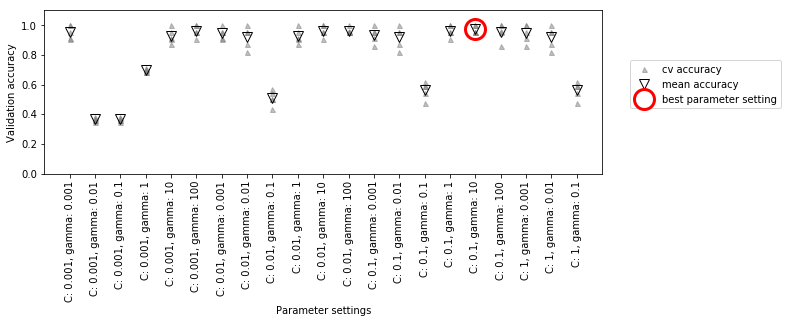

In [9]:
mglearn.plots.plot_cross_val_selection()

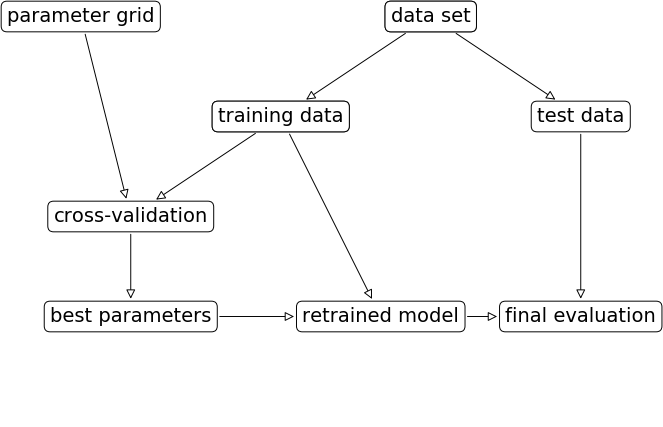

In [10]:
mglearn.plots.plot_grid_search_overview()

交差検証を用いたグリッドサーチは一般的
GridSearchCVクラスがscikit-learnにある

ディクショナリを用いて探索したいパラメータ指定する

In [11]:
############## ディクショナリ作成

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
print("Parameter grid:\n{}".format(param_grid))

Parameter grid:
{'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}


In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

grid_search = GridSearchCV(SVC(), param_grid, cv=5)

#param_gridで指定したディクショナリに従って、SVCのグリッドサーチ　かつ、５分割交差検証を行うクラス分類器作成
#最適なパラメータ決定

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    iris.data, iris.target, random_state=0)

#X_train X_testはデータ　y_train,y_testはクラス分類

In [14]:
grid_search.fit(X_train, y_train)
#訓練

GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [15]:
print("Test set score: {:.2f}".format(grid_search.score(X_test, y_test)))
#テストスコア

Test set score: 0.97


In [16]:
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))
#ベストスコア

Best parameters: {'C': 100, 'gamma': 0.01}
Best cross-validation score: 0.97


In [17]:
print("Best estimator:\n{}".format(grid_search.best_estimator_))

#estimator 使ったクラス分類器のパラメータ等表示

Best estimator:
SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


5.2.3.1 交差検証の結果の解析

In [18]:
import pandas as pd
# convert to Dataframe
results = pd.DataFrame(grid_search.cv_results_)
#cv_results_にグリッドサーチの結果格納
# show the first 5 rows
display(results.head())

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_C,param_gamma,params,rank_test_score,split0_test_score,split0_train_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.000400,0.0008,0.366071,0.366079,0.001,0.001,"{'C': 0.001, 'gamma': 0.001}",22,0.375,0.363636,...,0.363636,0.366667,0.363636,0.366667,0.380952,0.362637,0.000490,0.0004,0.011371,0.002852
1,0.000600,0.0002,0.366071,0.366079,0.001,0.01,"{'C': 0.001, 'gamma': 0.01}",22,0.375,0.363636,...,0.363636,0.366667,0.363636,0.366667,0.380952,0.362637,0.000490,0.0004,0.011371,0.002852
2,0.001002,0.0000,0.366071,0.366079,0.001,0.1,"{'C': 0.001, 'gamma': 0.1}",22,0.375,0.363636,...,0.363636,0.366667,0.363636,0.366667,0.380952,0.362637,0.000002,0.0000,0.011371,0.002852
3,0.000801,0.0002,0.366071,0.366079,0.001,1,"{'C': 0.001, 'gamma': 1}",22,0.375,0.363636,...,0.363636,0.366667,0.363636,0.366667,0.380952,0.362637,0.000400,0.0004,0.011371,0.002852
4,0.000400,0.0002,0.366071,0.366079,0.001,10,"{'C': 0.001, 'gamma': 10}",22,0.375,0.363636,...,0.363636,0.366667,0.363636,0.366667,0.380952,0.362637,0.000490,0.0004,0.011371,0.002852


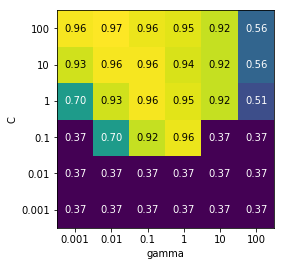

In [19]:
scores = np.array(results.mean_test_score).reshape(6, 6)
#パラメータ6で探索しているので

# plot the mean cross-validation scores
mglearn.tools.heatmap(scores, xlabel='gamma', xticklabels=param_grid['gamma'],
                      ylabel='C', yticklabels=param_grid['C'], cmap="viridis")

パラメータの設定重要　37％から97％まで変動している
パラメータの探索　細かすぎてもよくない

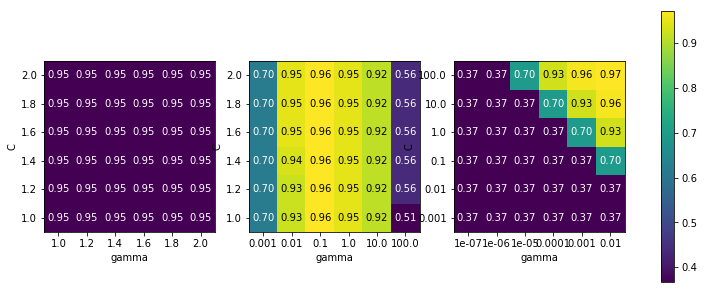

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(13, 5))

param_grid_linear = {'C': np.linspace(1, 2, 6),
                     'gamma':  np.linspace(1, 2, 6)}

param_grid_one_log = {'C': np.linspace(1, 2, 6),
                      'gamma':  np.logspace(-3, 2, 6)}

param_grid_range = {'C': np.logspace(-3, 2, 6),
                    'gamma':  np.logspace(-7, -2, 6)}

for param_grid, ax in zip([param_grid_linear, param_grid_one_log,
                           param_grid_range], axes):
    grid_search = GridSearchCV(SVC(), param_grid, cv=5)
    grid_search.fit(X_train, y_train)
    scores = grid_search.cv_results_['mean_test_score'].reshape(6, 6)

    # plot the mean cross-validation scores
    scores_image = mglearn.tools.heatmap(
        scores, xlabel='gamma', ylabel='C', xticklabels=param_grid['gamma'],
        yticklabels=param_grid['C'], cmap="viridis", ax=ax)

plt.colorbar(scores_image, ax=axes.tolist())

5.2.3.2　グリッドでないサーチ空間

In [21]:
#kernel 指定
param_grid = [{'kernel': ['rbf'],
               'C': [0.001, 0.01, 0.1, 1, 10, 100],
               'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
              {'kernel': ['linear'],
               'C': [0.001, 0.01, 0.1, 1, 10, 100]}]
print("List of grids:\n{}".format(param_grid))

List of grids:
[{'kernel': ['rbf'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}, {'kernel': ['linear'], 'C': [0.001, 0.01, 0.1, 1, 10, 100]}]


In [22]:
grid_search = GridSearchCV(SVC(), param_grid, cv=5)
grid_search.fit(X_train, y_train)

print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Best parameters: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
Best cross-validation score: 0.97


In [23]:
results = pd.DataFrame(grid_search.cv_results_)
# we display the transposed table so that it better fits on the page:
display(results.T.head())

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
mean_fit_time,0.000400305,0.00100408,0.000600576,0.000200129,0.000803518,0.00100298,0.00100212,0.000801945,0.000596476,0.000395012,...,0.000600386,0.000400209,0.00100355,0.00100613,0.000400209,0.000400352,0.000600433,0.000404119,0.000403786,0.0004004
mean_score_time,0.000399065,0,0.000400257,0.000600529,0.000197506,0,0,0.000400734,0.000200224,0.000400162,...,0.000400352,0.000197363,0,0.000397778,0,0.000400209,0,0.000196743,0,0.00020113
mean_test_score,0.366071,0.366071,0.366071,0.366071,0.366071,0.366071,0.366071,0.366071,0.366071,0.366071,...,0.955357,0.946429,0.919643,0.5625,0.366071,0.848214,0.946429,0.973214,0.964286,0.964286
mean_train_score,0.366079,0.366079,0.366079,0.366079,0.366079,0.366079,0.366079,0.366079,0.366079,0.366079,...,0.988788,1,1,1,0.366079,0.855069,0.966538,0.984368,0.988813,0.993258
param_C,0.001,0.001,0.001,0.001,0.001,0.001,0.01,0.01,0.01,0.01,...,100,100,100,100,0.001,0.01,0.1,1,10,100


5.2.3.4　ネストした交差検証


In [25]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

#cross_val_score()がついている
scores = cross_val_score(GridSearchCV(SVC(), param_grid, cv=5),
                         iris.data, iris.target, cv=5)
print("Cross-validation scores: ", scores)
print("Mean cross-validation score: ", scores.mean())

Cross-validation scores:  [ 0.96666667  1.          0.96666667  0.96666667  1.        ]
Mean cross-validation score:  0.98


具体的には…

In [26]:
def nested_cv(X, y, inner_cv, outer_cv, Classifier, parameter_grid):
    outer_scores = []
    # for each split of the data in the outer cross-validation
    # (split method returns indices of training and test part)
    for training_samples, test_samples in outer_cv.split(X, y):
        # find best parameter using inner cross-validation
        best_parms = {}
        best_score = -np.inf
        # iterate over parameters
        for parameters in parameter_grid:
            # accumulate score over inner splits
            cv_scores = []
            # iterate over inner cross-validation
            for inner_train, inner_test in inner_cv.split(
                    X[training_samples], y[training_samples]):
                # build classifier given parameters and training data
                clf = Classifier(**parameters)
                clf.fit(X[inner_train], y[inner_train])
                # evaluate on inner test set
                score = clf.score(X[inner_test], y[inner_test])
                cv_scores.append(score)
            # compute mean score over inner folds
            mean_score = np.mean(cv_scores)
            if mean_score > best_score:
                # if better than so far, remember parameters
                best_score = mean_score
                best_params = parameters
        # build classifier on best parameters using outer training set
        clf = Classifier(**best_params)
        clf.fit(X[training_samples], y[training_samples])
        # evaluate
        outer_scores.append(clf.score(X[test_samples], y[test_samples]))
    return np.array(outer_scores)

In [27]:
from sklearn.model_selection import ParameterGrid, StratifiedKFold
scores = nested_cv(iris.data, iris.target, StratifiedKFold(5),
                   StratifiedKFold(5), SVC, ParameterGrid(param_grid))
print("Cross-validation scores: {}".format(scores))

Cross-validation scores: [ 0.96666667  1.          0.96666667  0.96666667  1.        ]


6＊6＊5＊5の900通り存在する
計算量ヤバい

5.2.3.5 交差検証とグリッドサーとの並列化　（単純並列）

上記だと計算量ヤバい…
特定の交差検証の分割に対する特定のパラメータ設定は独立に実行できる！
複数のＰＣ使いましょう
scikit-learnには実装されていない。spark-sklearnにあります
使い方は
https://github.com/databricks/spark-sklearn にパッケージある

↑これ、自分たち使えるんじゃない？